In [1]:
import copy
import os
import random
import time
import timeit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from torch import optim
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, models, transforms

from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
)

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

print(os.listdir("../data/Brain Tumor Data Set/Brain Tumor Data Set/"))

['Brain Tumor', 'Healthy']


In [3]:
datadir = "../data/Brain Tumor Data Set/Brain Tumor Data Set/"

# traindir = f"{datadir}train/"
# testdir = f"{datadir}test/"
# validdir = f"{datadir}val/"

save_file_name = "vgg19-brain.pt"
checkpoint_path = "vgg19-brain.pth"

In [4]:
BATCH_SIZE = 64
NUM_GPU = torch.cuda.device_count() if torch.cuda.is_available() else 0

device = torch.device("cuda:0" if NUM_GPU else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
categories: list[str] = []
img_categories: list[str] = []
n_train: list[int] = []
n_valid: list[int] = []
n_test: list[int] = []
hs: list[int] = []
ws: list[int] = []

In [6]:
for item in os.listdir(datadir):
    # if item.startswith('.'):
    #     continue

    categories.append(item)

    train_imgs = os.listdir(datadir + item)
    # valid_imgs = os.listdir(validdir + item)
    # test_imgs = os.listdir(testdir + item)

    n_train.append(len(train_imgs))
    # n_valid.append(len(valid_imgs))
    # n_test.append(len(test_imgs))

    for img in train_imgs:
        if img.startswith('.'):
            continue

        img_categories.append(item)
        image = Image.open(datadir + item + '/' + img)
        # img_array = np.array(img)

        hs.append(image.height)
        ws.append(image.width)

In [7]:
cat_df = pd.DataFrame({
    "category": categories,
    "n_train": n_train,
    # "n_valid": n_valid,
    # "n_test": n_test
})

cat_df.head()

,category,n_train
0,Brain Tumor,2513
1,Healthy,2087


<AxesSubplot: xlabel='category'>

(array([0, 1]), [Text(0, 0, 'Brain Tumor'), Text(1, 0, 'Healthy')])

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training images by category')

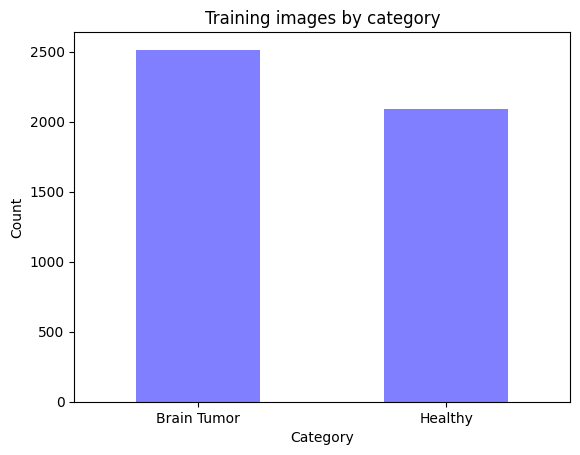

In [8]:
cat_df.set_index("category")['n_train'].plot.bar(color='b', alpha=0.5)

plt.xticks(rotation=0)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Training images by category")
plt.show()

In [9]:
image_df = pd.DataFrame({
    "category": img_categories,
    "height": hs,
    "width": ws
})

image_df.head()

,category,height,width
0,Brain Tumor,512,512
1,Brain Tumor,300,240
2,Brain Tumor,256,256
3,Brain Tumor,512,512
4,Brain Tumor,256,256


In [10]:
img_dsc = image_df.groupby('category').mean()

min_width = image_df.sort_values(by=['width'])
# min_height = image_df.sort_values(by=['height'])

min_width.head()
# min_height.head()

print(img_dsc)

,category,height,width
4383,Healthy,198,150
2707,Healthy,198,150
3428,Healthy,198,150
4257,Healthy,198,150
2693,Healthy,198,150


                 height       width
category                           
Brain Tumor  432.991643  402.872264
Healthy      313.258745  307.249161


<Figure size 1000x600 with 0 Axes>

<AxesSubplot: xlabel='height', ylabel='Density'>

<AxesSubplot: xlabel='height', ylabel='Density'>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

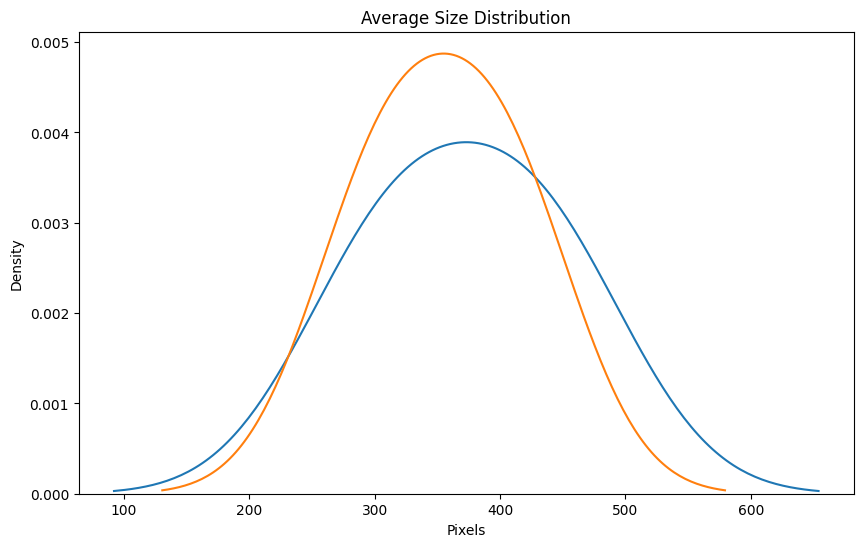

In [11]:
plt.figure(figsize=(10, 6))

sns.kdeplot(img_dsc['height'], label='Average Height')
sns.kdeplot(img_dsc['width'], label='Average Width')

plt.xlabel("Pixels")
plt.ylabel("Density")
plt.title("Average Size Distribution")

In [12]:
def show(image, title: str=""):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

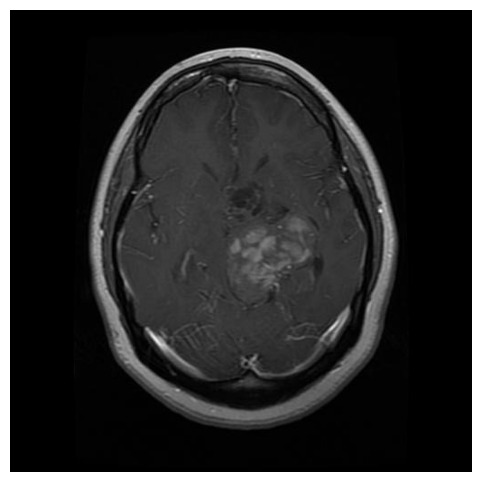

Image Size: 512 x 512


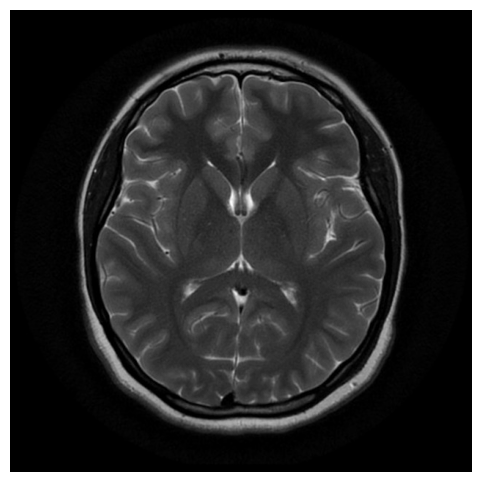

Image Size: 630 x 630


In [13]:
x = Image.open(f"{datadir}Brain Tumor/Cancer (1).jpg")
show(x)
print(f"Image Size: {x.width} x {x.height}")

y = Image.open(f"{datadir}Healthy/Not Cancer  (1).jpeg")
show(y)
print(f"Image Size: {y.width} x {y.height}")

In [14]:
# Data Transformations and Normalization for Training and Validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
image_datasets = datasets.ImageFolder(datadir, data_transforms['train'])
dataloaders = DataLoader(image_datasets, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dataset_size = len(image_datasets)
class_names = image_datasets.classes

print(f"Dataset Size: {dataset_size}")
print(f"Normal Images: {class_names[0]}")
print(f"Brain Tumor Images: {class_names[1]}")
print(f"Classes: {class_names}")

Dataset Size: 4600
Normal Images: Brain Tumor
Brain Tumor Images: Healthy
Classes: ['Brain Tumor', 'Healthy']


In [16]:
def imshow(inp: torch.Tensor , title: str | None = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

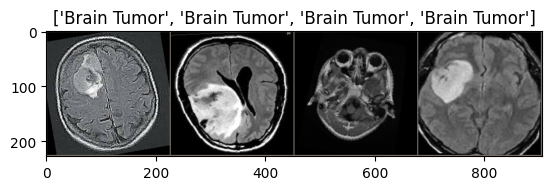

In [17]:
# Get a batch of training data and select the first 4 images
inputs, classes = next(iter(dataloaders))

# Make a grid from batch and select the first 4 images
out = torchvision.utils.make_grid(inputs[:4])
# out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes[:4]])

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label'
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(), 
        rotation=45, 
        ha="right", 
        rotation_mode="anchor"
    )

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt), 
                ha="center", va="center", 
                color="white" if cm[i, j] > thresh else "black"
            )
    fig.tight_layout()
    plt.show()
    
    return ax

In [19]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    avg_precision = average_precision_score(y_true, y_score)
    
    plt.step(recall, precision, color='b', alpha=0.25, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f"Two-class Precision-Recall curve: AP={avg_precision:0.2f}")
    plt.show()


In [20]:
def plot_classification_report(y_true, y_pred, figsize=(10,10)):
    cr = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))
    
    categories = list(cr.keys())
    categories = [x for x in categories if x not in ['micro avg', 'macro avg', 'weighted avg',]]
    categories.sort()

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([0, 1], [0, 1])
    ax.set_yticks(range(len(categories)))
    ax.set_yticklabels(categories)
    ax.xaxis.tick_top()
    ax.set_xlabel('Score')
    ax.set_ylabel('Metric')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for i, category in enumerate(categories):
        if category == 'accuracy':
            continue
        
        precision = cr.get(category, {}).get('precision', 0)
        recall = cr.get(category, {}).get('recall', 0)
        f1 = cr.get(category, {}).get('f1-score', 0)
        ax.barh(i, precision, color='b', alpha=0.5)
        ax.barh(i, recall, color='g', alpha=0.5)
        ax.barh(i, f1, color='r', alpha=0.5)


    plt.tight_layout()
    plt.legend()
    plt.show()


In [21]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr, tpr,  lw=lw, 
        color='r', alpha=0.5,
        label='ROC curve (area = %0.2f)' % roc_auc
    )
    plt.plot([0, 1], [0, 1], color='b', alpha=0.5, lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [22]:
def plot_loss_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.plot(history['train_loss'], label='train loss', color='b', alpha=0.5)
    ax1.plot(history['val_loss'], label='val loss', color='r', alpha=0.5)
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(history['train_acc'], label='train acc', color='b', alpha=0.5)
    ax2.plot(history['val_acc'], label='val acc', color='r', alpha=0.5)
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

In [23]:
def visualize_model(model, num_images: int=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(
                    f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}', 
                    fontdict={'size': 10}
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
def visualize_model(model, num_images: int=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(
                    f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}', 
                    fontdict={'size': 10}
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs: int=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    all_y_true = []
    all_y_pred = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_y_true += labels.tolist()
                all_y_pred += preds.tolist()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = (running_corrects.double() / dataset_size).cpu().numpy()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print('Classification Report:')
    plot_classification_report(all_y_true, all_y_pred)
    print('Confusion Matrix:')
    
    plot_confusion_matrix(all_y_true, all_y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

    plot_precision_recall_curve(all_y_true, all_y_pred)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [26]:
model_ft = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_ft = nn.DataParallel(model_ft)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Using 2 GPUs!


Epoch 0/24
----------


c:\Users\Administrator\Documents\1707057\Thesis\venv\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


train Loss: 0.3588 Acc: 0.8257
val Loss: 0.1262 Acc: 0.9554

Epoch 1/24
----------
train Loss: 0.1018 Acc: 0.9654
val Loss: 0.0535 Acc: 0.9830

Epoch 2/24
----------
train Loss: 0.0667 Acc: 0.9750
val Loss: 0.0464 Acc: 0.9830

Epoch 3/24
----------
train Loss: 0.0282 Acc: 0.9920
val Loss: 0.0168 Acc: 0.9954

Epoch 4/24
----------
train Loss: 0.0215 Acc: 0.9924
val Loss: 0.0128 Acc: 0.9967

Epoch 5/24
----------
train Loss: 0.0201 Acc: 0.9950
val Loss: 0.0073 Acc: 0.9978

Epoch 6/24
----------
train Loss: 0.0156 Acc: 0.9946
val Loss: 0.0070 Acc: 0.9983

Epoch 7/24
----------
train Loss: 0.0062 Acc: 0.9985
val Loss: 0.0028 Acc: 0.9996

Epoch 8/24
----------
train Loss: 0.0051 Acc: 0.9983
val Loss: 0.0049 Acc: 0.9985

Epoch 9/24
----------
train Loss: 0.0069 Acc: 0.9978
val Loss: 0.0037 Acc: 0.9993

Epoch 10/24
----------
train Loss: 0.0053 Acc: 0.9983
val Loss: 0.0039 Acc: 0.9989

Epoch 11/24
----------
train Loss: 0.0049 Acc: 0.9985
val Loss: 0.0034 Acc: 0.9991

Epoch 12/24
----------
t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    125650
           1       0.99      0.99      0.99    104350

    accuracy                           0.99    230000
   macro avg       0.99      0.99      0.99    230000
weighted avg       0.99      0.99      0.99    230000



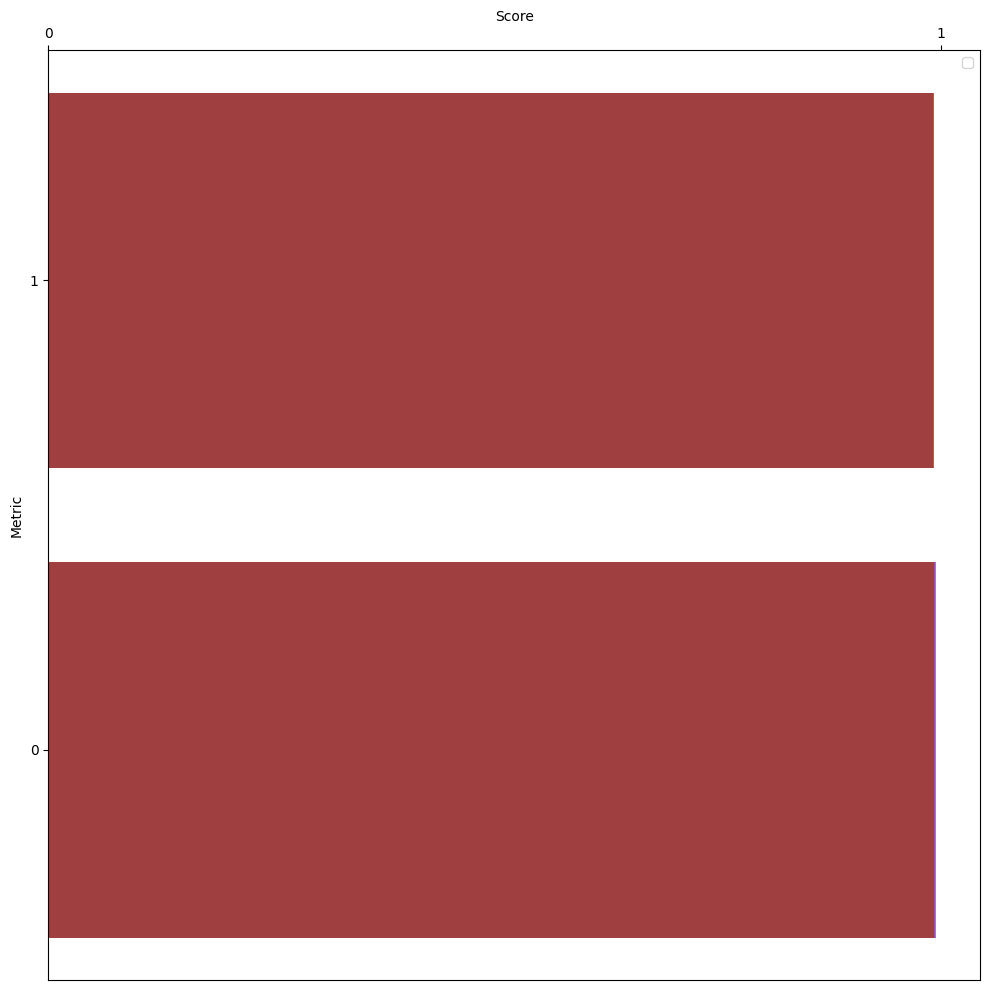

Confusion Matrix:
Normalized confusion matrix
[[0.99221647 0.00778353]
 [0.00766651 0.99233349]]


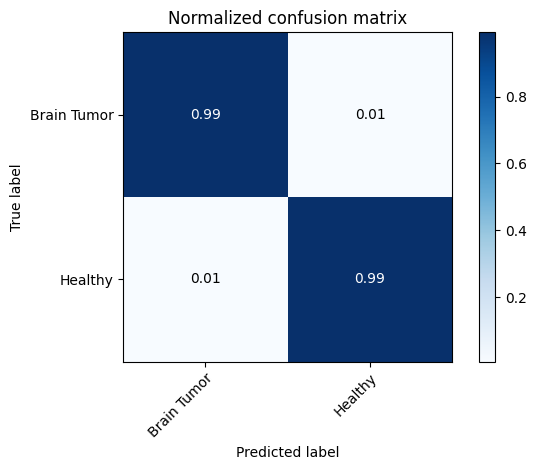

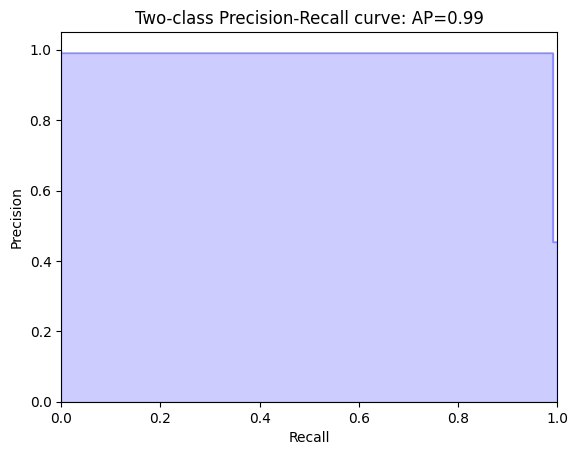

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

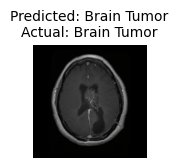

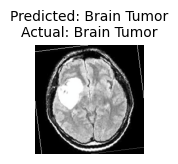

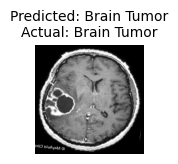

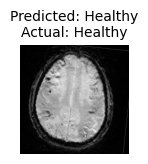

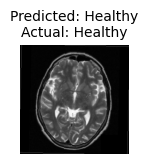

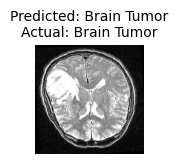

In [28]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [29]:
model_conv = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_conv = nn.DataParallel(model_conv)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Using 2 GPUs!


Epoch 0/24
----------


c:\Users\Administrator\Documents\1707057\Thesis\venv\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


train Loss: 0.5230 Acc: 0.7370
val Loss: 0.3865 Acc: 0.8243

Epoch 1/24
----------
train Loss: 0.4686 Acc: 0.7828
val Loss: 0.3501 Acc: 0.8498

Epoch 2/24
----------
train Loss: 0.4272 Acc: 0.8043
val Loss: 0.3270 Acc: 0.8617

Epoch 3/24
----------
train Loss: 0.4176 Acc: 0.8065
val Loss: 0.3186 Acc: 0.8691

Epoch 4/24
----------
train Loss: 0.3851 Acc: 0.8257
val Loss: 0.3343 Acc: 0.8554

Epoch 5/24
----------
train Loss: 0.4090 Acc: 0.8078
val Loss: 0.3095 Acc: 0.8707

Epoch 6/24
----------
train Loss: 0.3894 Acc: 0.8263
val Loss: 0.2947 Acc: 0.8785

Epoch 7/24
----------
train Loss: 0.3650 Acc: 0.8328
val Loss: 0.2935 Acc: 0.8791

Epoch 8/24
----------
train Loss: 0.3687 Acc: 0.8300
val Loss: 0.2856 Acc: 0.8874

Epoch 9/24
----------
train Loss: 0.3721 Acc: 0.8350
val Loss: 0.2922 Acc: 0.8822

Epoch 10/24
----------
train Loss: 0.3545 Acc: 0.8393
val Loss: 0.2882 Acc: 0.8887

Epoch 11/24
----------
train Loss: 0.3749 Acc: 0.8309
val Loss: 0.2860 Acc: 0.8896

Epoch 12/24
----------
t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.87      0.86      0.87    125650
           1       0.84      0.84      0.84    104350

    accuracy                           0.85    230000
   macro avg       0.85      0.85      0.85    230000
weighted avg       0.85      0.85      0.85    230000



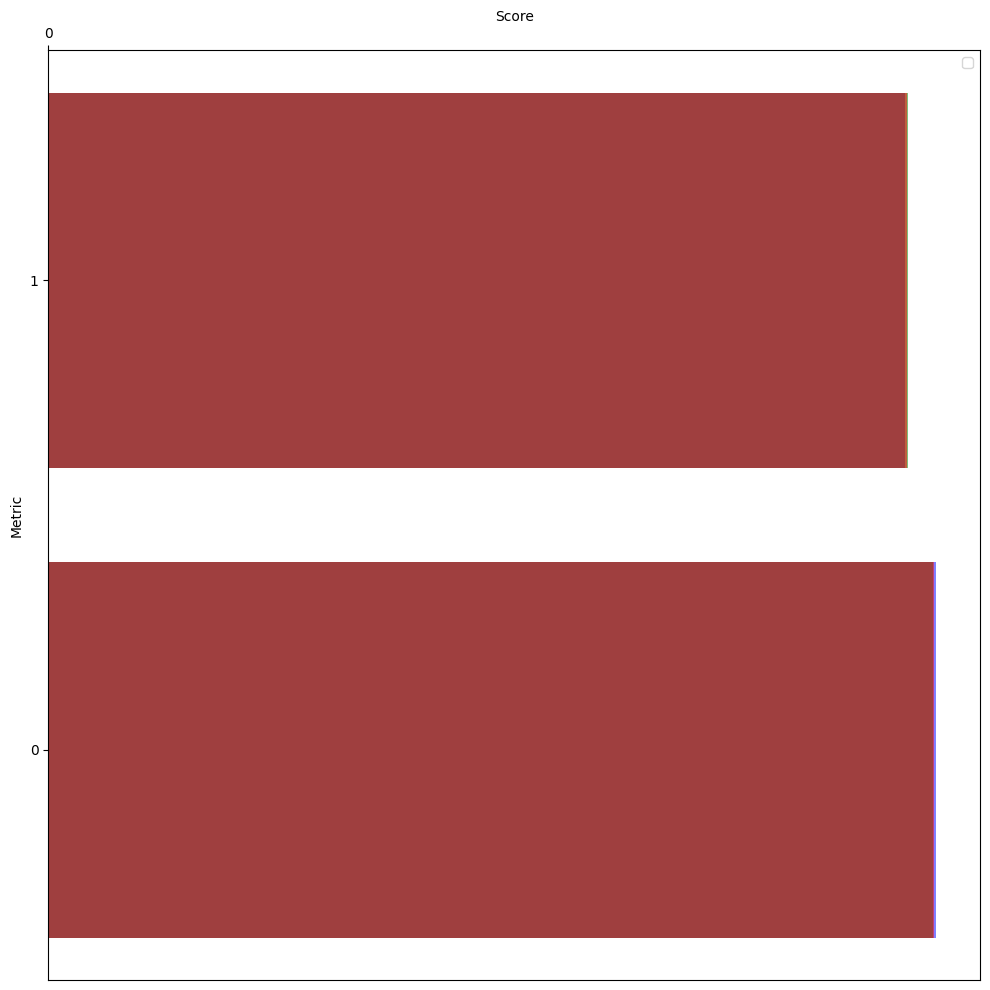

Confusion Matrix:
Normalized confusion matrix
[[0.86417827 0.13582173]
 [0.15951126 0.84048874]]


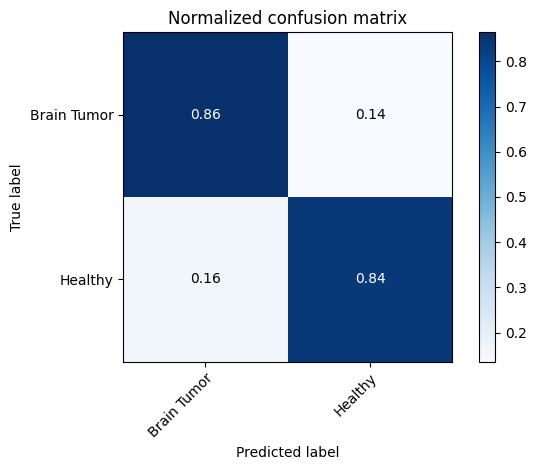

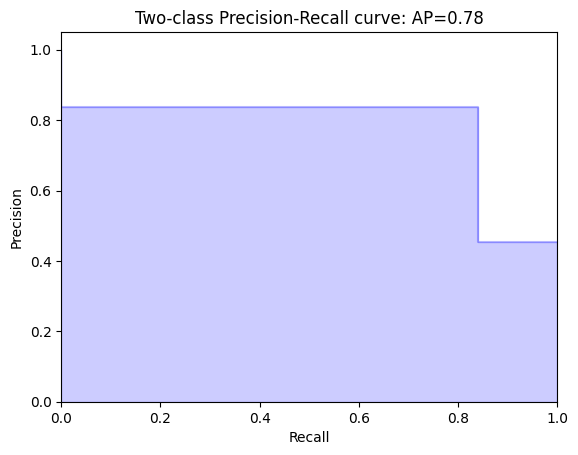

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)